In [1]:
import sys         

import pandas as pd
import numpy as np
from scipy.stats import iqr

from ppc_db import sql_extractdata

sys.path.append(r'C:\Users\jamie\OneDrive\Python\Py_24\Git_master\econ')
import fred

db_args = {
    'user':'root',
    'password':'password',
    'host':'localhost',
    'port':3306,
    'database':'CSV_DB 7'
 }

In [2]:
cols = ['7_county', 'price_gbp']

query = f"SELECT {", ".join(str(x) for x in cols)} FROM Oct24pricepaidcomplete WHERE YEAR(date)=2023"
result = pd.DataFrame(sql_extractdata(query, **db_args),columns=cols)

df = (result.join
      (pd.read_csv('county_to_region.csv',
                   index_col='7_county',
                   dtype=str),
                   on='7_county')
     )

In [3]:
df_median = pd.DataFrame()


for i in range(1995,2024+1,1):
    cols = ['7_county', 'price_gbp']
    query = f"SELECT {", ".join(str(x) for x in cols)} FROM Oct24pricepaidcomplete WHERE YEAR(date)="+str(i)
    result = pd.DataFrame(sql_extractdata(query, **db_args),columns=['7_county',i])

    df = (result.join
        (pd.read_csv('county_to_region.csv',
                    index_col='7_county',
                    dtype=str),
                    on='7_county')
        )
    
    df_median = pd.concat([df_median,df.groupby('region')[i].quantile(q=0.5)],axis=1)

In [4]:
# df_quantiles = pd.DataFrame()
# for j in [10]:
#     df_quantiles[j] = df.groupby('region')[i].quantile(j/100)

In [53]:
#Nominal

df_median_screened = df_median.transpose().drop(['East of England','Yorkshire and the Humber','South West','West Midlands','Wales'],axis=1)

import plotly.express as px
fig = px.line(df_median_screened.apply(lambda x: x/x.iloc[0],axis=0),
              labels={
                  'index':'Year',
                  'value':'Relative Price'
              },
              width=800, height=600,
              title='Median House Prices, Nominal GBP')

fig.update_layout(legend=dict(
    title='Region',
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

In [51]:
df_median_screened = df_median.transpose().drop(['East of England','Yorkshire and the Humber','South West','West Midlands','Wales'],axis=1)

gbp_cpi = (
    fred.Fred_Pull('GBRCPIALLMINMEI',
                   '899901ba06f09b9961a73113b1834a15').index(1995)
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

import plotly.express as px
fig = px.line(df_median_screened.mul(gbp_cpi.values,axis=1)
              .apply(lambda x: x/x.iloc[0],axis=0),
              labels={
                  'index':'Year',
                  'value':'Relative Price'
              },
              width=800, height=600,
              title='Median House Prices, CPI Adjusted GBP (1995)')

fig.update_layout(legend=dict(
    title='Region',
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

In [59]:
# Post-GFC

gbp_cpi = (
    fred.Fred_Pull('GBRCPIALLMINMEI',
                   '899901ba06f09b9961a73113b1834a15').index(2007)
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

import plotly.express as px
fig = px.line(df_median_screened.loc[df_median_screened.index>2006].mul(gbp_cpi.values,axis=1).apply(lambda x: x/x.iloc[0],axis=0),
              labels={
                  'index':'Year',
                  'value':'Relative Price'
              },
              width=800, height=600,
              title='Median House Prices, CPI Adjusted GBP (2007)')

fig.update_layout(legend=dict(
    title='Region',
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

In [77]:
us_cpi = (
    fred.Fred_Pull('CPIAUCSL',
                   '899901ba06f09b9961a73113b1834a15').index(2007)
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

In [80]:
us_cpi

,CPIAUCSL
year,
2007,0.981281
2008,0.945249
2009,0.948210
2010,0.932892
2011,0.904542
2012,0.886131
2013,0.873315
2014,0.859426
2015,0.858396


In [65]:
gbpusd_fx = (
    fred.Fred_Pull('DEXUSUK',
                   '899901ba06f09b9961a73113b1834a15').extract(2007)
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

In [88]:
usdreal = (gbpusd_fx[gbpusd_fx.index>2006]
           .join(us_cpi)
           .assign(real=lambda df:df['DEXUSUK']*df['CPIAUCSL'])
)

In [89]:
usdreal

,DEXUSUK,CPIAUCSL,real
year,,,
2007,2.001653,0.981281,1.964184
2008,1.852181,0.945249,1.750773
2009,1.565189,0.948210,1.484128
2010,1.546518,0.932892,1.442734
2011,1.603695,0.904542,1.450609
2012,1.585550,0.886131,1.405006
2013,1.564762,0.873315,1.366530
2014,1.647472,0.859426,1.415880
2015,1.528523,0.858396,1.312079


In [102]:
# Post-GFC, Real US$

import plotly.express as px

us_cpi = (
    fred.Fred_Pull('CPIAUCSL',
                   '899901ba06f09b9961a73113b1834a15').index(1995)
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

gbpusd_fx = (
    fred.Fred_Pull('DEXUSUK',
                   '899901ba06f09b9961a73113b1834a15').extract(1995)
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

usdreal = (gbpusd_fx[gbpusd_fx.index>1994]
           .join(us_cpi)
           .assign(real=lambda df:df['DEXUSUK']*df['CPIAUCSL'])
)


fig = px.line(df_median_screened.mul(usdreal['real'].values,axis=0).apply(lambda x: x/x.iloc[0],axis=0),
              labels={
                  'index':'Year',
                  'value':'Relative Price'
              },
              width=800, height=600,
              title='Median House Prices, CPI Adjusted US$ (1995)')

fig.update_layout(legend=dict(
    title='Region',
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

Real Wages

In [219]:
# Average Weekly Earnings Per Person in the United Kingdom (FROM Q1 1919)

nominal_wages_gbp = (
    fred.Fred_Pull('AWEPPUKQ',
                   '899901ba06f09b9961a73113b1834a15').extract()
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

# Residential Property Prices for United Kingdom (FROM Q2 1846)

nominal_resproperty_gbp = (
    fred.Fred_Pull('HPIUKA',
                   '899901ba06f09b9961a73113b1834a15').extract()
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

# Household Variable Mortgage Rate in the United Kingdom (FROM 1853)

nominal_mortrate_perc = (
    fred.Fred_Pull('CMRAUKA',
                   '899901ba06f09b9961a73113b1834a15').extract()
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

# Inflation, consumer prices for the United Kingdom (FROM 1960)

gbp_cpi_percent = (
    fred.Fred_Pull('FPCPITOTLZGGBR',
                   '899901ba06f09b9961a73113b1834a15').extract()
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

# Consumer Price Indices ..., COICOP 1999: Consumer Price Index... (FROM 1914)

gbp_cpi = (
    fred.Fred_Pull('CPIUKQ',
                   '899901ba06f09b9961a73113b1834a15').extract()
                   .apply(lambda x:1/(x/x.iloc[-1]))
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

In [253]:
df = (
    nominal_wages_gbp.join([nominal_resproperty_gbp,nominal_mortrate_perc,gbp_cpi_percent,gbp_cpi])
    .assign(real_prop_gbp = lambda df:df['HPIUKA']*df['CPIUKQ'],
            real_wages_gbp = lambda df: df['AWEPPUKQ']*df['CPIUKQ'],
            nominal_mortrate_perc = lambda df: df['CMRAUKA']
            )
)

#df=df.loc[df.index<2007]

In [248]:
import seaborn as sns

fig = px.scatter(df,x='real_wages_gbp',y='real_prop_gbp',
              labels={
                  'real_wages_gbp':'Average Weekly Earnings',
                  'real_prop_gbp':'Residential Property Price Index'
              },
              width=800, height=600, trendline="ols",
              title='UK House Price Index vs. Weekly Earnings, CPI Adjusted GBP (2024)')

fig.update_layout(legend=dict(
    title='Region',
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

In [235]:
fig = px.scatter(df,x='nominal_mortrate_perc',y='real_prop_gbp',
              labels={
                  'nominal_mortrate_perc':'Nominal Mortgage Rate',
                  'real_prop_gbp':'Residential Property Price Index'
              },
              width=800, height=600, trendline="ols",
              title='UK House Price Index (CPI Adjusted GBP, 2024) vs. Nominal Mortgage Rates (%)')

fig.update_layout(legend=dict(
    title='Region',
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

<Axes: xlabel='year', ylabel='real_wages_gbp'>

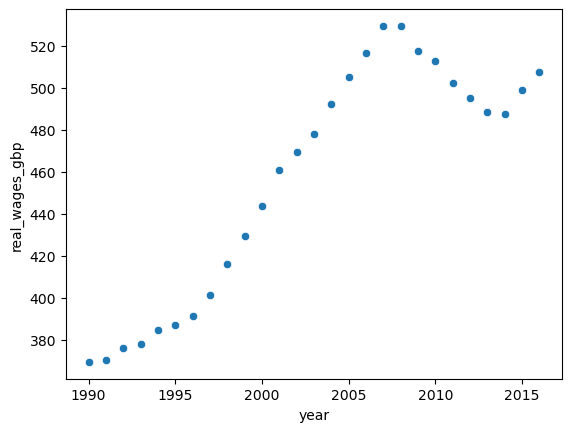

In [254]:
import seaborn as sns
df_test = df.loc[df.index>1989]
sns.scatterplot(x=df_test.index,y=df_test['real_wages_gbp'])

,AWEPPUKQ,HPIUKA,CMRAUKA,FPCPITOTLZGGBR,CPIUKQ,real_prop_gbp,real_wages_gbp,nominal_mortrate_perc
year,,,,,,,,
2001,334.0000,52.10,6.44,1.532350,1.379597,71.876987,460.785290,6.44
2002,344.5850,60.75,5.39,1.520402,1.362454,82.769066,469.481128,5.39
2003,355.6650,69.44,4.96,1.376500,1.344134,93.336668,478.061435,4.96
2004,371.1675,77.68,5.28,1.390398,1.326360,103.031653,492.301763,5.28
2005,388.5000,81.94,5.47,2.089136,1.299602,106.489383,504.895353,5.47
2006,406.7475,88.38,5.35,2.455662,1.270070,112.248765,516.597697,5.35
